# ✅ 通用代码

In [7]:
%matplotlib inline

import torch
import torchvision

from torch import nn
import d2l_torch as d2l

import os

In [2]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

# ✅ 使用normalization的情况

In [4]:
def train_fine_tuning(net,lr,batch_size=128,num_epochs=5,param_group=True):
    """
    大部分和之前都差不多，不过有一个param_group，用来区分fc层和其它层学习率的参数
    非fc层是小的学习率，fc层的学习率是其它层的学习率的10倍
    因此非fc层是 1x，而fc层是10x（表示1倍学习率和10倍学习率）
    """
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none") 
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer=torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),'lr': lr * 10}],lr=lr,weight_decay=0.001)
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=lr,weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [3]:
normalize=torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_augs=torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                          torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.ToTensor(),
                                          normalize])

test_augs=torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                         torchvision.transforms.RandomCrop(224),
                                         torchvision.transforms.ToTensor(),
                                         normalize])

In [5]:
finetune_net=torchvision.models.resnet18(pretrained=True)
finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2) 
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0531, -0.0374, -0.0780,  ..., -0.0778,  0.0109,  0.0410],
        [ 0.0216,  0.0507, -0.0227,  ..., -0.0898, -0.0611,  0.0692]],
       requires_grad=True)

loss 0.235, train acc 0.902, test acc 0.936
168.2 examples/sec on [device(type='cuda', index=0)]


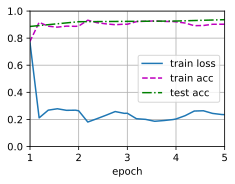

In [8]:
train_fine_tuning(finetune_net, batch_size=64,lr=5e-5)

# ✅ 使用BN的情况

In [16]:
train_augs=torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                          torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.ToTensor()])

test_augs=torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                         torchvision.transforms.RandomCrop(224),
                                         torchvision.transforms.ToTensor()])

In [17]:
finetune_BN=torchvision.models.resnet18(pretrained=True)
finetune_BN.fc=nn.Linear(finetune_net.fc.in_features,2) 
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0908,  0.0809,  0.0623,  ...,  0.0940, -0.0680,  0.0496],
        [-0.0495,  0.0432, -0.0910,  ..., -0.0753, -0.0727, -0.0386]],
       device='cuda:0', requires_grad=True)

In [18]:
net=nn.Sequential(nn.BatchNorm2d(num_features=3,track_running_stats=False),
                  finetune_BN)

In [19]:
net[0].weight,net[0].bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [29]:
dict(net.named_parameters()).keys()

dict_keys(['0.weight', '0.bias', '1.conv1.weight', '1.bn1.weight', '1.bn1.bias', '1.layer1.0.conv1.weight', '1.layer1.0.bn1.weight', '1.layer1.0.bn1.bias', '1.layer1.0.conv2.weight', '1.layer1.0.bn2.weight', '1.layer1.0.bn2.bias', '1.layer1.1.conv1.weight', '1.layer1.1.bn1.weight', '1.layer1.1.bn1.bias', '1.layer1.1.conv2.weight', '1.layer1.1.bn2.weight', '1.layer1.1.bn2.bias', '1.layer2.0.conv1.weight', '1.layer2.0.bn1.weight', '1.layer2.0.bn1.bias', '1.layer2.0.conv2.weight', '1.layer2.0.bn2.weight', '1.layer2.0.bn2.bias', '1.layer2.0.downsample.0.weight', '1.layer2.0.downsample.1.weight', '1.layer2.0.downsample.1.bias', '1.layer2.1.conv1.weight', '1.layer2.1.bn1.weight', '1.layer2.1.bn1.bias', '1.layer2.1.conv2.weight', '1.layer2.1.bn2.weight', '1.layer2.1.bn2.bias', '1.layer3.0.conv1.weight', '1.layer3.0.bn1.weight', '1.layer3.0.bn1.bias', '1.layer3.0.conv2.weight', '1.layer3.0.bn2.weight', '1.layer3.0.bn2.bias', '1.layer3.0.downsample.0.weight', '1.layer3.0.downsample.1.weight', '

In [32]:
net[1].fc

Linear(in_features=512, out_features=2, bias=True)

In [33]:
def train_fine_tuning(net,lr,batch_size=128,num_epochs=5,param_group=True):
    """
    大部分和之前都差不多，不过有一个param_group，用来区分fc层和其它层学习率的参数
    非fc层是小的学习率，fc层的学习率是其它层的学习率的10倍
    因此非fc层是 1x，而fc层是10x（表示1倍学习率和10倍学习率）
    """
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none") 
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["1.fc.weight", "1.fc.bias"]]
        trainer=torch.optim.SGD([{'params': params_1x}, {'params': net[1].fc.parameters(),'lr': lr * 10}],lr=lr,weight_decay=0.001)
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=lr,weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

loss 0.196, train acc 0.916, test acc 0.860
169.9 examples/sec on [device(type='cuda', index=0)]


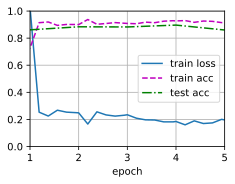

In [34]:
train_fine_tuning(net, batch_size=64,lr=5e-5)

In [37]:
finetune_BN=torchvision.models.resnet18(pretrained=True)
finetune_BN.fc=nn.Linear(finetune_net.fc.in_features,2) 
nn.init.xavier_uniform_(finetune_net.fc.weight)
net=nn.Sequential(nn.BatchNorm2d(num_features=3,track_running_stats=True),
                  finetune_BN)

loss 0.152, train acc 0.940, test acc 0.935
169.3 examples/sec on [device(type='cuda', index=0)]


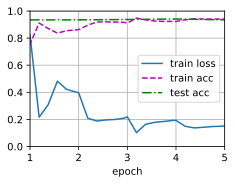

In [38]:
train_fine_tuning(net, batch_size=64,lr=5e-5)

# ✅ 向预训练模型添加层的问题

参考：https://discuss.pytorch.org/t/add-layers-on-pretrained-model/88760

In [59]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True)
resnet50.fc = nn.Identity()

In [60]:
sample = torch.randn(1, 3, 224, 224)
resnet50(sample).size()

torch.Size([1, 2048])

In [65]:
class DisMultModel(nn.Module):
    def __init__(self, hidden_dim):
        super(DisMultModel, self).__init__()
        self.hidden_dim = hidden_dim
        # 模型中加入一层DisMult层
        self.dismult = DisMult(hidden_dim)
 
    def forward(self, x_a, x_b):
        return self.dismult(x_a, x_b)

In [66]:
DisMultModel

__main__.DisMultModel

In [62]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(2048, 128)
        
        self.branch_a1 = nn.Linear(128, 32)
        self.branch_a2 = nn.Linear(32, 1)
        
        self.branch_b1 = nn.Linear(128, 5)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        
        # branch a
        a = F.leaky_relu(self.branch_a1(x))
        out1 = self.branch_a2(a)
        
        # branch b
        out2 = self.branch_b1(x)
        return (out1, out2)

In [63]:
model = nn.Sequential(resnet50, net_add)

In [54]:
net_add=net()

参考：[pytorch custom layer "is not a Module subclass"](https://stackoverflow.com/questions/44406819/pytorch-custom-layer-is-not-a-module-subclass)

+ 一开始上面代码报错：`__main__.net  is not a Module subclass`
+ 我以为是自定义层/网络 有问题，尝试了网上另一个代码，发现也是错的。
+ 查了之后，发现是忘了实例化类了。。。无语

# ✅ 使用热狗数据集自己的均值方差来进行normalization

热狗数据集：
+ 均值为：tensor([0.5734, 0.4586, 0.2882])，方差为：tensor([0.2108, 0.2169, 0.1982])

ImageNet：
+ normalize=torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

loss 0.200, train acc 0.915, test acc 0.940
177.6 examples/sec on [device(type='cuda', index=0)]


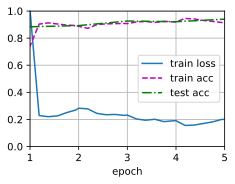

In [69]:
normalize=torchvision.transforms.Normalize(mean=[0.5734, 0.4586, 0.2882], std=[0.2108, 0.2169, 0.1982])

train_augs=torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                          torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.ToTensor(),
                                          normalize])

test_augs=torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                         torchvision.transforms.RandomCrop(224),
                                         torchvision.transforms.ToTensor(),
                                         normalize])

finetune_net=torchvision.models.resnet18(pretrained=True)
finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2) 
nn.init.xavier_uniform_(finetune_net.fc.weight)

def train_fine_tuning(net,lr,batch_size=128,num_epochs=5,param_group=True):
    """
    大部分和之前都差不多，不过有一个param_group，用来区分fc层和其它层学习率的参数
    非fc层是小的学习率，fc层的学习率是其它层的学习率的10倍
    因此非fc层是 1x，而fc层是10x（表示1倍学习率和10倍学习率）
    """
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none") 
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer=torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),'lr': lr * 10}],lr=lr,weight_decay=0.001)
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=lr,weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

train_fine_tuning(finetune_net, batch_size=64,lr=5e-5)